### 4. Multi-Objective Robust Optimization (MORO)

After establishing in in notebook "3_comparison", that any policies will lead to reduction of the number of seaths and the damaegies in both provinces. Since the damage for the Overifessel a signiffficantly lower than those for Gelderland, next step is to find the most favourable and acceptable policy for all the involved actors and examine if that policy serves the interet of Overijessel, regarding their interests and preferences. This will be achieved by using Many Objective Robust Optimization (MORO).

The result of the scenario discovery done in this notebook is reported and analyzed in section 4.4 of the report. 

### 0. Inporting Libraries

In [1]:
# Import libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import functools
import math
import pickle

# Import workbench libraries
from ema_workbench import (Model, CategoricalParameter, ScalarOutcome, IntegerParameter, RealParameter)
from ema_workbench import (MultiprocessingEvaluator, Policy, Scenario, Constraint)
from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging, utilities
from ema_workbench import (MultiprocessingEvaluator, ema_logging, 
                           perform_experiments, SequentialEvaluator)
from ema_workbench.em_framework.optimization import (HyperVolume, 
                                                     EpsilonProgress)
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.em_framework import sample_uncertainties
from ema_workbench.analysis import parcoords

# Import dike model 
from problem_formulation_new import get_model_for_problem_formulation
from dike_model_function import DikeNetwork 

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

### 1. Loading Data

In [2]:
# Load in the results from experiments conducted for 100 ranndom policies over 500 scenarios.
experiments, outcomes = utilities.load_results('results/500_scenarios_100_policies.csv')

# Transform the outcomes to a dataframe.
df_outcomes = pd.DataFrame(outcomes)

#Making a dataframe.
combined = pd.concat([experiments,df_outcomes],axis=1,sort=False)

[MainProcess/INFO] results loaded succesfully from C:\Users\ASUS\PycharmProjects\EPA1361\EPA1361_final\results\500_scenarios_100_policies.csv


The aggregation is done with the aggregate function 'aggregate_kpi' created in "aggragation_function.py"

In [3]:
# Importing aggragation_function used to aggregate the outcomes into the KPI we want.
# This iterates over all the locations and round numbers, and creates a new column summing the values per location and round.
# If we want to aggregate over the location, "aggregate" equals "location" and therefore the KPI is added per location and not in total.
# If we want to aggregate over the province, "aggregate" equals "province" and therefore the KPI is added per province.
# On the contrary, if aggregate equals "total", the total value is appended to the dataframe.
from aggragation_function import aggregate_kpi

# Append the KPIs we would like to analyse.
combined = combined.reset_index(drop=True)
combined = aggregate_kpi(combined, "Expected Number of Deaths", "total")
combined = aggregate_kpi(combined, "RfR Total Costs", "total")
combined = aggregate_kpi(combined, "Expected Evacuation Costs", "total")
combined = aggregate_kpi(combined, "Expected Annual Damage", "total")
combined = aggregate_kpi(combined, "Dike Investment Costs", "total")


In [4]:
combined.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2,Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Expected Annual Damage,Dike Investment Costs
0,86.0,125.377672,1.5,0.223847,201.899302,10.0,0.171458,62.319867,10.0,0.481647,...,0.0,5.055076e+07,0.0,121200000.0,0.0,0.000580,710400000.0,171.567079,5.277757e+06,7.147383e+08
1,126.0,335.991641,1.0,0.227941,319.126769,1.0,0.164486,262.169187,10.0,0.719170,...,0.0,5.055076e+07,0.0,121200000.0,0.0,0.003759,710400000.0,1345.966416,2.353271e+07,7.147383e+08
2,124.0,203.152265,10.0,0.742322,175.030541,1.5,0.387297,90.071139,10.0,0.827419,...,0.0,5.055076e+07,0.0,121200000.0,0.0,0.000094,710400000.0,60.019692,1.511530e+06,7.147383e+08
3,84.0,124.941025,10.0,0.377310,242.317500,1.0,0.841154,292.575014,1.5,0.801661,...,0.0,5.055076e+07,0.0,121200000.0,0.0,0.000000,710400000.0,0.000000,0.000000e+00,7.147383e+08
4,4.0,338.347068,1.0,0.759608,191.747037,10.0,0.605795,339.519262,10.0,0.174419,...,0.0,5.055076e+07,0.0,121200000.0,0.0,0.007787,710400000.0,1405.596354,2.977891e+07,7.147383e+08


### Robustness functions ###

    - To set the limits of the variables the 25% percentile is used based on the data set retrived in "3_comparison"
    - The model is instantiante for Problem Formulation 2, which provide 5 outcomes aggrageted at the system wide level.
           - Expected Number of Deaths
           - Expected Annual Damage
           - Dike Investment Costs
           - RfR Total Costs
           - Expected Evacuation Costs
    - The aggragation level is chosen because the Overijssel does not suffer significant damage and the policy of most interst for them is RfR projects upstream.
    - The 3 uncertainties indetified in notebook "2_sceario_discovery" which contrubute most to the worst case scenarios are used.
    - For the robustnes_functions the 90th percentile regret function.

In [5]:
MINIMIZE = ScalarOutcome.MINIMIZE

percentile90 = functools.partial(np.percentile, q=90)

#Specifying robustness functions. All have to be minimized. All use 90th percentile regret function.

robustnes_functions = [ScalarOutcome('90th percentile Death Number', kind=MINIMIZE, variable_name='Expected Number of Deaths',
                                      function=percentile90 ),
                        ScalarOutcome('90th percentile Annual Costs', kind=MINIMIZE, variable_name='Expected Annual Damage',
                                      function=percentile90 ),
                        ScalarOutcome('90th percentile Dike Costs', kind=MINIMIZE, variable_name='Dike Investment Costs',
                                      function=percentile90 ),
                        ScalarOutcome('90th percentile RfR Cost', kind=MINIMIZE, variable_name='RfR Investment Costs', 
                                      function=percentile90 ),
                        ScalarOutcome('90th percentile Evacuation', kind=MINIMIZE, variable_name='Evacuation Costs', 
                                      function=percentile90 )]

In [6]:
# The 25 percentile are difine as the max values on which will optimeze over
death_25 = np.percentile(combined["Expected Number of Deaths"], 25)
annual_dmg_25= np.percentile(combined["Expected Annual Damage"], 25)
dike_25 = np.percentile(combined["Dike Investment Costs"], 25)
rfr_25 = np.percentile(combined["RfR Total Costs"], 25)
evac_25 = np.percentile(combined["Expected Evacuation Costs"], 25)

In [7]:
# Instantiate the model
dike_model, planning_steps = get_model_for_problem_formulation(2)

def sum_over(*args):
    return sum(args)

# Redefine the uncertainties
dike_model.uncertainties['A.1_pfail'] = RealParameter('A.1_pfail', 0, 0.4)
dike_model.uncertainties['A.3_pfail'] = RealParameter('A.3_pfail', 0, 0.21)
dike_model.uncertainties['A.1_Bmax'] = RealParameter('A.1_Bmax', 30, 330)

### MORO Set up ###

    - The convergence limits are set to be between 0 and the 25% percentile of every respectable variable.
    - The optimization is run over 20 scenarios, mainly on time issues,  however all of this sceanrios are worst-case.
    - The chosen nfe (5000) is too low as well as '$\epsilon$-progress' graph shows, the metric are not fully converged. 
    - The higher number of optimel policies is mainly due to the low epsilons for some of the variables.
 

In [8]:
#Performing MORO: specifying the scenarios, the convergence metrics, 
# the number of function evaluations and performing the robust_optimize function.
n_scenarios = 20
scenarios = sample_uncertainties(dike_model, n_scenarios)

convergence = [HyperVolume(minimum=[0,0,0,0,0], 
                           maximum=[death_25, annual_dmg_25, dike_25,rfr_25,evac_25 ]),
               EpsilonProgress()]

nfe = int(5000) # that is too low value, probably more like 50 0000

# with MultiprocessingEvaluator(dike_model) as evaluator:
#     archive, convergence = evaluator.robust_optimize(robustnes_functions, scenarios, 
#                                                nfe=nfe, convergence=convergence,
#                                                epsilons=[0.01]*len[robustnes_functions] # should not be 
#                                                     )
# with open('results/MORORun.pkl', 'wb') as file_pi:
#     pickle.dump((archive, convergence), file_pi)

archive, convergence = pickle.load(open('results/MORORun.pkl', 'rb'))

archive

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,90th percentile Death Number,90th percentile Annual Costs,90th percentile Dike Costs,90th percentile RfR Cost,90th percentile Evacuation
0,0,0,0,0,1,0,1,0,1,0,...,0,8,9,5,1,0.015157,2.298371e+07,5.861966e+08,279200000.0,0.000000
1,0,0,0,0,0,0,0,0,1,0,...,2,7,10,6,0,0.021604,9.842250e+07,5.033186e+08,30700000.0,3240.025753
2,0,0,1,0,0,0,0,0,1,0,...,1,7,5,5,1,0.013781,6.624533e+07,4.527149e+08,115300000.0,2515.310445
3,1,1,0,0,0,0,1,0,1,1,...,0,7,10,6,2,0.001270,1.904687e+06,7.442815e+08,473000000.0,0.000000
4,1,0,0,0,0,0,1,0,1,0,...,4,7,9,5,2,0.001764,7.633041e+06,5.546162e+08,146000000.0,278.843098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.130694,1.177945e+09,1.749656e+08,84600000.0,32329.653277
331,0,0,0,0,0,0,0,0,0,0,...,2,3,7,0,1,0.424362,4.920025e+08,2.856472e+08,0.0,0.000000
332,0,0,1,0,0,0,0,0,0,1,...,6,6,8,5,0,0.045484,8.392576e+07,5.232540e+08,205800000.0,0.000000
333,0,0,1,0,0,0,1,0,0,0,...,0,1,0,4,0,0.565891,6.058225e+08,2.176126e+08,115300000.0,0.000000


### Results ###

**Convergence**


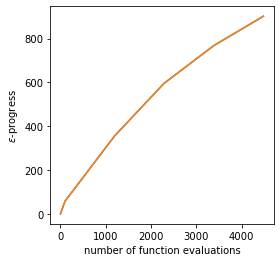

In [14]:
fig, (ax1) = plt.subplots(ncols=1, sharex=True, figsize=(4, 4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')

plt.plot(convergence.nfe, convergence.epsilon_progress)
plt.ylabel('$\epsilon$-progress')
plt.xlabel('number of function evaluations')
plt.savefig("images/convergence.png")
plt.show()

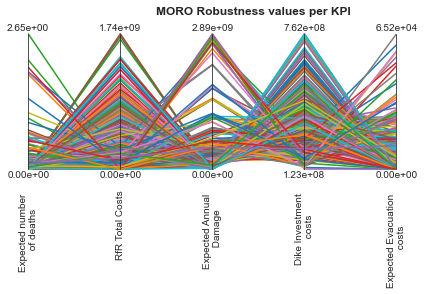

In [49]:
#Creating the parallel coordinate plot. For the legend, mlines has to be imported.
import matplotlib.lines as mlines


#Selecting the variables to be plotted and their corresponding names in the figure
outcomes = archive.loc[:,['90th percentile Death Number',
                          '90th percentile RfR Cost',
                          '90th percentile Annual Costs',
                          '90th percentile Dike Costs',
                          '90th percentile Evacuation']]

outcomes.columns = ['Expected number \n of deaths',
                    'RfR Total Costs',
                    'Expected Annual \n Damage',
                    'Dike Investment \n costs',
                    'Expected Evacuation \n costs']

#Creating the axes for the correct limits and in the correct format
limits=parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits, fontsize=10, formatter={i: ".2e" for i in outcomes.columns})

#Drawing the lines. This is done with a for loop, because then each line can be given a color,
#and this is the only way we found to create a legend with such a plot
for policy in range(len(outcomes.values)):
    axes.plot(outcomes.iloc[policy,:])

plt.title("MORO Robustness values per KPI", fontdict={'horizontalalignment':"right", 'fontweight':'bold'})
plt.savefig("images/Robustness_tradeoffs_MORO.png")
plt.show()

In [45]:
# Convert the policy dataframe to policy-objects
# policy_list = []
# for row in range(archive.shape[0]):
#     policy_list.append(Policy(name=(row+1), **archive.iloc[row, :-5].to_dict()))

# # Instantiate the model
# dike_model, planning_steps = get_model_for_problem_formulation(5)

# # Running the experiments (commented out)

# with MultiprocessingEvaluator(dike_model, n_processes = 10) as evaluator:
#     results = evaluator.perform_experiments(scenarios=100, policies=policy_list)
# utilities.save_results(results, 'results/100_scenarios_best_policies_PF5.csv')


experiments, outcomes = utilities.load_results('results/100_scenarios_best_policies_PF5.csv')

# Turn into a dataframe
df_outcomes = pd.DataFrame(outcomes)
results = pd.concat([experiments,df_outcomes],axis=1,sort=False)

# Let the policy counter start from 1 in stead of 0
rename = lambda x: "policy " + str(int(x.split()[1])+1)
results["policy"] = results["policy"].apply(rename)

results.head()

[MainProcess/INFO] results loaded succesfully from C:\Users\ASUS\PycharmProjects\EPA1361\EPA1361_final\results\100_scenarios_best_policies_PF5.csv


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_Dike Investment Costs 2,A.3_Expected Number of Deaths 2,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
0,85.0,108.015501,1.0,0.347832,89.935444,10.0,0.603416,118.769130,10.0,0.996802,...,0,0.0,0.0,1.781735e+07,0.0,0.0,4.007542e+07,0.0,30700000.0,0.0
1,98.0,172.298606,1.5,0.928822,131.301243,1.0,0.061775,175.790742,10.0,0.702736,...,0,0.0,0.0,1.781735e+07,0.0,0.0,4.007542e+07,0.0,30700000.0,0.0
2,66.0,284.264801,1.0,0.291558,323.205034,10.0,0.368597,165.096696,1.5,0.103236,...,0,0.0,0.0,1.781735e+07,0.0,0.0,4.007542e+07,0.0,30700000.0,0.0
3,1.0,203.406227,1.5,0.888315,114.941407,1.5,0.971012,199.016287,1.5,0.449870,...,0,0.0,0.0,1.781735e+07,0.0,0.0,4.007542e+07,0.0,30700000.0,0.0
4,101.0,317.828312,1.5,0.437019,305.380376,1.0,0.115759,301.532652,1.5,0.017279,...,0,0.0,0.0,1.781735e+07,0.0,0.0,4.007542e+07,0.0,30700000.0,0.0


In [46]:
# Importing aggragation_function used to aggregate the outcomes into the KPI we want.
# This iterates over all the locations and round numbers, and creates a new column summing the values per location and round.
# If we want to aggregate over the location, "aggregate" equals "location" and therefore the KPI is added per location and not in total.
# If we want to aggregate over the province, "aggregate" equals "province" and therefore the KPI is added per province.
# On the contrary, if aggregate equals "total", the total value is appended to the dataframe.
from aggragation_function import aggregate_kpi

# Append the KPIs we would like to analyse.
results= results.reset_index(drop=True)
results = aggregate_kpi(results, "Expected Number of Deaths", "province")
results = aggregate_kpi(results, "Expected Annual Damage", "province")
results = aggregate_kpi(results, "Dike Investment Costs", "province")
results = aggregate_kpi(results, "RfR Total Costs", "total")
results = aggregate_kpi(results, "Expected Evacuation Costs", "total")

In [47]:
# crating data frame with outcome of interest
results_ooi = results[["policy", 
                            "Overijssel_Expected Number of Deaths", 
                            "Gelderland_Expected Number of Deaths",
                            'Overijssel_Expected Annual Damage',
                            'Gelderland_Expected Annual Damage',
                            'Overijssel_Dike Investment Costs',
                            'Gelderland_Dike Investment Costs',
                            'RfR Total Costs',
                            'Expected Evacuation Costs']]


In [48]:
# add column for the total policy cost
results_ooi["Total Policy Costs"] = results_ooi.loc[:, ("RfR Total Costs",
                                              "Expected Evacuation Costs",
                                              "Gelderland_Dike Investment Costs",
                                              "Overijssel_Dike Investment Costs")].sum(axis=1)

results_ooi.head()

C:\Users\ASUS\miniconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,policy,Overijssel_Expected Number of Deaths,Gelderland_Expected Number of Deaths,Overijssel_Expected Annual Damage,Gelderland_Expected Annual Damage,Overijssel_Dike Investment Costs,Gelderland_Dike Investment Costs,RfR Total Costs,Expected Evacuation Costs,Total Policy Costs
0,policy 2,0.000000,0.0,0.000000e+00,0.0,1.690875e+08,4.171091e+08,279200000.0,0.0,8.653966e+08
1,policy 2,0.002314,0.0,4.257257e+06,0.0,1.690875e+08,4.171091e+08,279200000.0,0.0,8.653966e+08
2,policy 2,0.000000,0.0,0.000000e+00,0.0,1.690875e+08,4.171091e+08,279200000.0,0.0,8.653966e+08
3,policy 2,0.031591,0.0,5.749485e+07,0.0,1.690875e+08,4.171091e+08,279200000.0,0.0,8.653966e+08
4,policy 2,0.000000,0.0,0.000000e+00,0.0,1.690875e+08,4.171091e+08,279200000.0,0.0,8.653966e+08


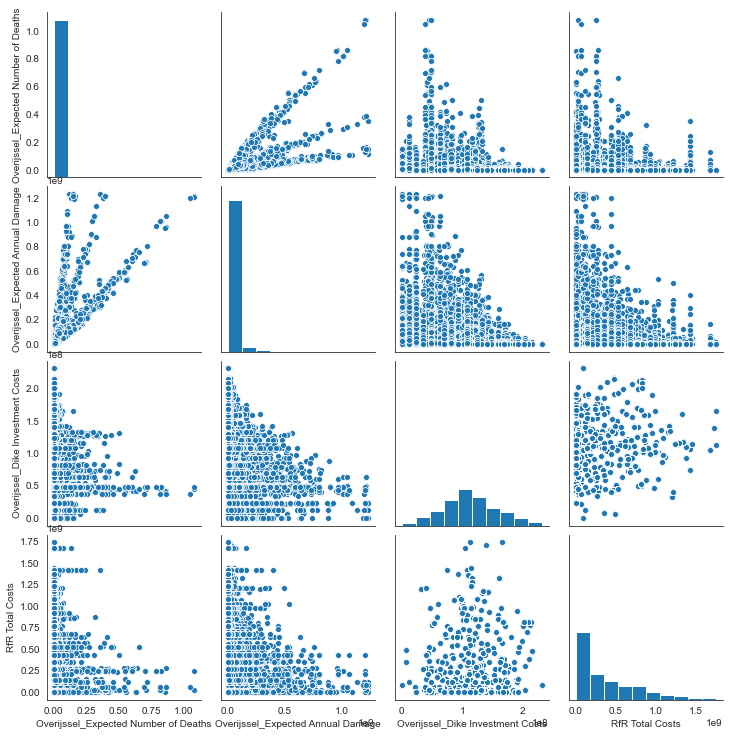

In [55]:
#Now that a combined dataframe has been created, plotting the base case against the random policy runs is now easy.
sns.pairplot(results_ooi, vars=["Overijssel_Expected Number of Deaths", 
                                'Overijssel_Expected Annual Damage',
                                'Overijssel_Dike Investment Costs', 
                                "RfR Total Costs"], diag_kind="hist")
plt.savefig("images/overijssel_best_policy.png")
plt.show()

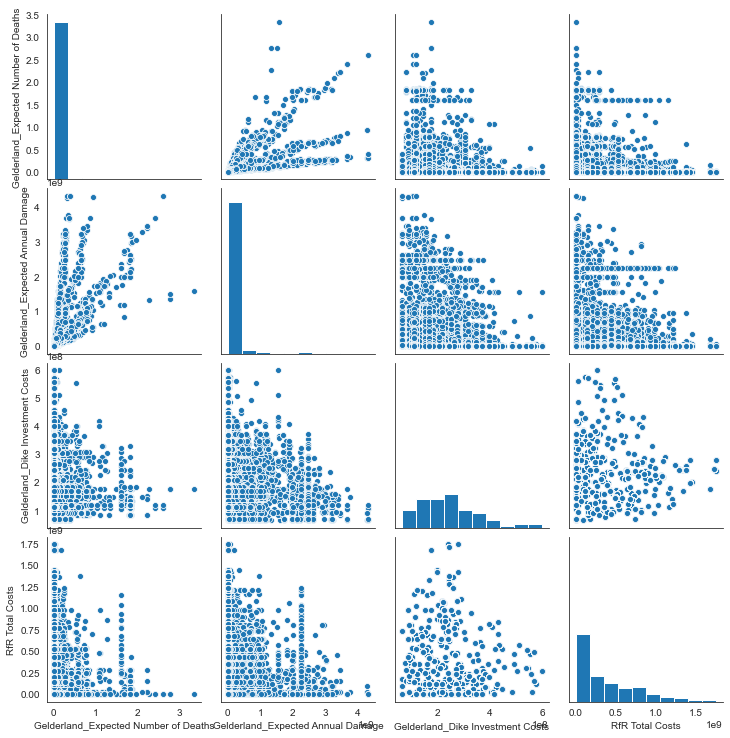

In [54]:
#Now that a combined dataframe has been created, plotting the base case against the random policy runs is now easy.
sns.pairplot(results_ooi, vars=["Gelderland_Expected Number of Deaths", 
                                'Gelderland_Expected Annual Damage',
                                'Gelderland_Dike Investment Costs', 
                                "RfR Total Costs"], diag_kind="hist")
plt.savefig("images/gelderland_best_policy.png")
plt.show()